In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as s
import numpy as np

Данные взяты из генеральной совокупности - все больные отделения реанимации с тяжелой сочетанной травмой. В генеральной совокупности данные распределены нормально.

In [2]:
df = pd.read_csv('hemodynamics.csv',index_col=0)
df.head()

,ID,AGE,Day,SBP,DBP,HR,GT,SpO2,Weight,OUTCOME
0,1,6.0,1,100.0,65.0,108.0,0.0,100.0,20.0,Survived
1,1,6.0,2,100.0,65.0,100.0,0.0,100.0,20.0,Survived
2,1,6.0,3,100.0,65.0,100.0,0.0,100.0,20.0,Survived
3,1,6.0,4,120.0,60.0,100.0,0.0,100.0,20.0,Survived
4,1,6.0,5,100.0,60.0,98.0,0.0,100.0,20.0,Survived


Имеется 2 группы больных с разным исходом заболевания (см. столбец OUTCOME)
<br>
1. Проверка гипотезы о том, что пациенты с различным исходом заболевания не имели разные дисперсии и принадлежали к одной и той же группе больных

    параметр GT исключен из этого анализа, т.к. является категориальным

In [3]:
def dispersion_analysis(array,alpha):
    all_values = np.hstack(array)
    F_stats,p_value = s.f_oneway(*array)
    F_critical_stats = s.f.ppf(1-alpha, len(array)-1, len(all_values)-len(array))

    return pd.DataFrame(data=[[F_stats,p_value, F_critical_stats,F_stats>F_critical_stats]],index = ['value'], columns=['F-статистика','p_value','F-критическое','Result'])

In [4]:
died = df.loc[df['OUTCOME']=='Died',:]
surv = df.loc[df['OUTCOME']=='Survived',:]
columns = df.columns[1:-1].drop('GT')
columns

Index(['AGE', 'Day', 'SBP', 'DBP', 'HR', 'SpO2', 'Weight'], dtype='object')

In [5]:
df_res = pd.DataFrame(columns=['F-статистика','p_value','F-критическое','Result'])
for i in columns:
    array = [died[i],surv[i]]
    res_df = dispersion_analysis(array,0.05)
    res_df = res_df.rename(index={'value':i})
    df_res = pd.concat([df_res,res_df])

In [6]:
df_res.sort_values('Result')

,F-статистика,p_value,F-критическое,Result
Day,2.225068,1.360133e-01,3.848148,False
HR,0.059869,8.067391e-01,3.848148,False
AGE,12.702774,3.774535e-04,3.848148,True
SBP,51.309504,1.274274e-12,3.848148,True
DBP,49.895312,2.553972e-12,3.848148,True
SpO2,41.435629,1.672353e-10,3.848148,True
Weight,23.218627,1.604206e-06,3.848148,True


2. Визуализация данных

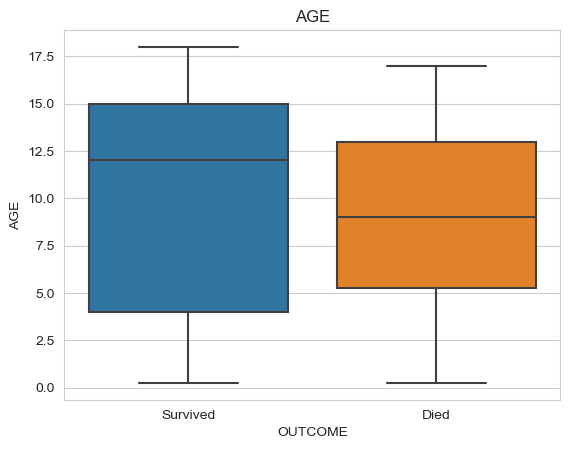

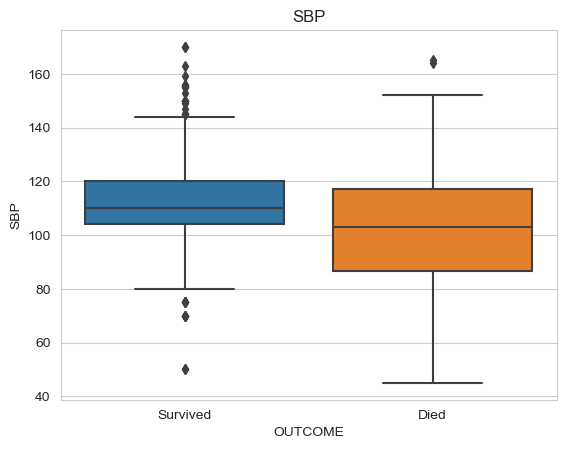

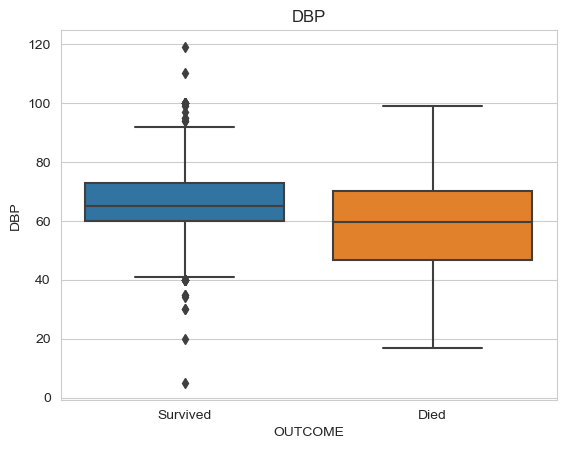

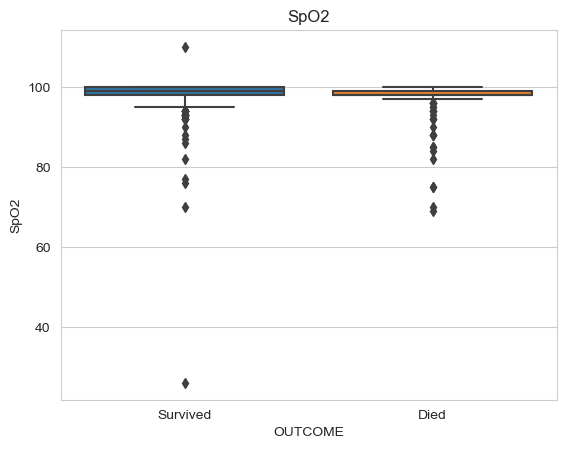

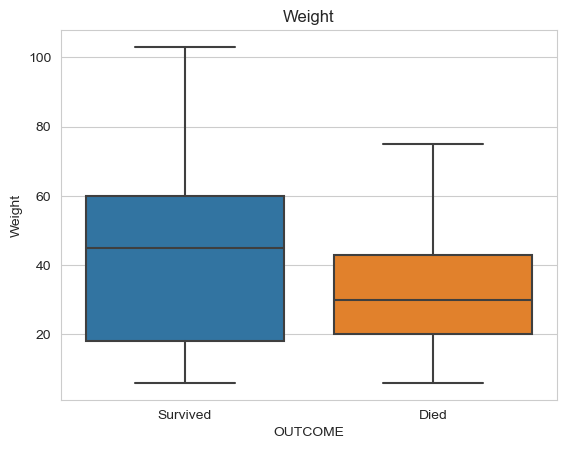

In [7]:
df_plot = df[df_res[df_res['Result']==True].index.to_list()+['OUTCOME']]
sns.set_style('whitegrid')
for i in df_plot.columns[:-1]:
    sns.boxplot(y = df_plot[i],x=df_plot['OUTCOME']);
    plt.title(i)
    plt.show()

На графиках бокс-плот видно, что группы пациентов с различным исходом трудно разделимы по значению каждого параметра, несмотря на то, что дисперсионный анализ показал, что различия между группами существуют (аналогично и для параметров, по которым разница не выявлена - см.ниже)

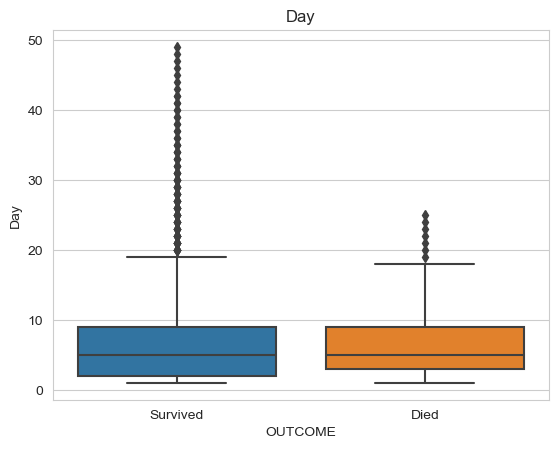

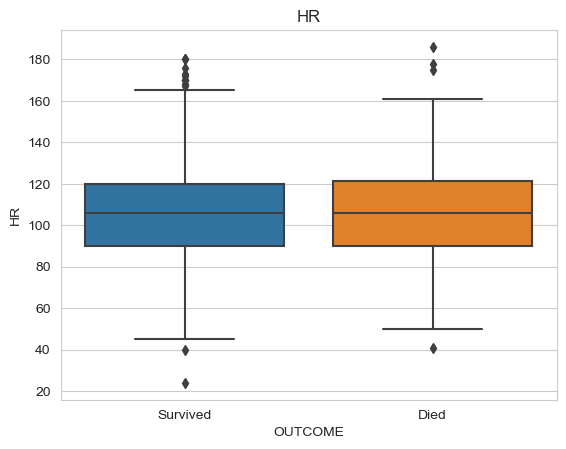

In [8]:
df_plot = df[df_res[df_res['Result']==False].index.to_list()+['OUTCOME']]
for i in df_plot.columns[:-1]:
    sns.boxplot(y = df_plot[i],x=df_plot['OUTCOME']);
    plt.title(i)
    plt.show()

3. Имеется сильная асимметрия выборки (см. ниже). В этом разделе предпринята попытка использования непараметрических методов анализа.

In [9]:
pd.DataFrame(df.groupby('ID')['OUTCOME'].value_counts()).drop(columns='OUTCOME').reset_index(1)['OUTCOME'].value_counts()

Survived    184
Died         19
Name: OUTCOME, dtype: int64

In [10]:
# т.к. группы пациентов разного размера, в одной из них - мало данных,
# распределение не нормальное (графики ниже), воспользуемся тестом Краскела-Уоллиса
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    group0 = df[df['OUTCOME']=='Survived'][i]
    group1 = df[df['OUTCOME']=='Died'][i]
    alpha = 0.05
    test_value, p  = s.kruskal(group0,group1)
    if alpha<p:
        # print(f'Разница по параметру {i} между двумя группами не доказана.')
        # print(f'\tСтатистика теста = {test_value}, p-значение = {p}')
        pass
    else:
        print(f'По параметру {i} наблюдается статистически достоверная разница между двумя группами.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')

По параметру AGE наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 16.85210553529865, p-значение = 4.0408475841657814e-05
По параметру SBP наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 33.76318914296964, p-значение = 6.224559899659991e-09
По параметру DBP наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 30.94542164671112, p-значение = 2.653873926318453e-08
По параметру SpO2 наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 63.48809377126654, p-значение = 1.6133903516751914e-15
По параметру Weight наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 18.094994453060067, p-значение = 2.101531665940721e-05


### Тест Краскела-Уоллиса показывает наличие значимой разницы по тем же параметрам, что были выявлены и ранее.
### На графиках видна разница в распределении значений параметров. Возможно, стоит попытаться использовать находки в данной работе вместе с дополнительными параметрами в машинном обучении.

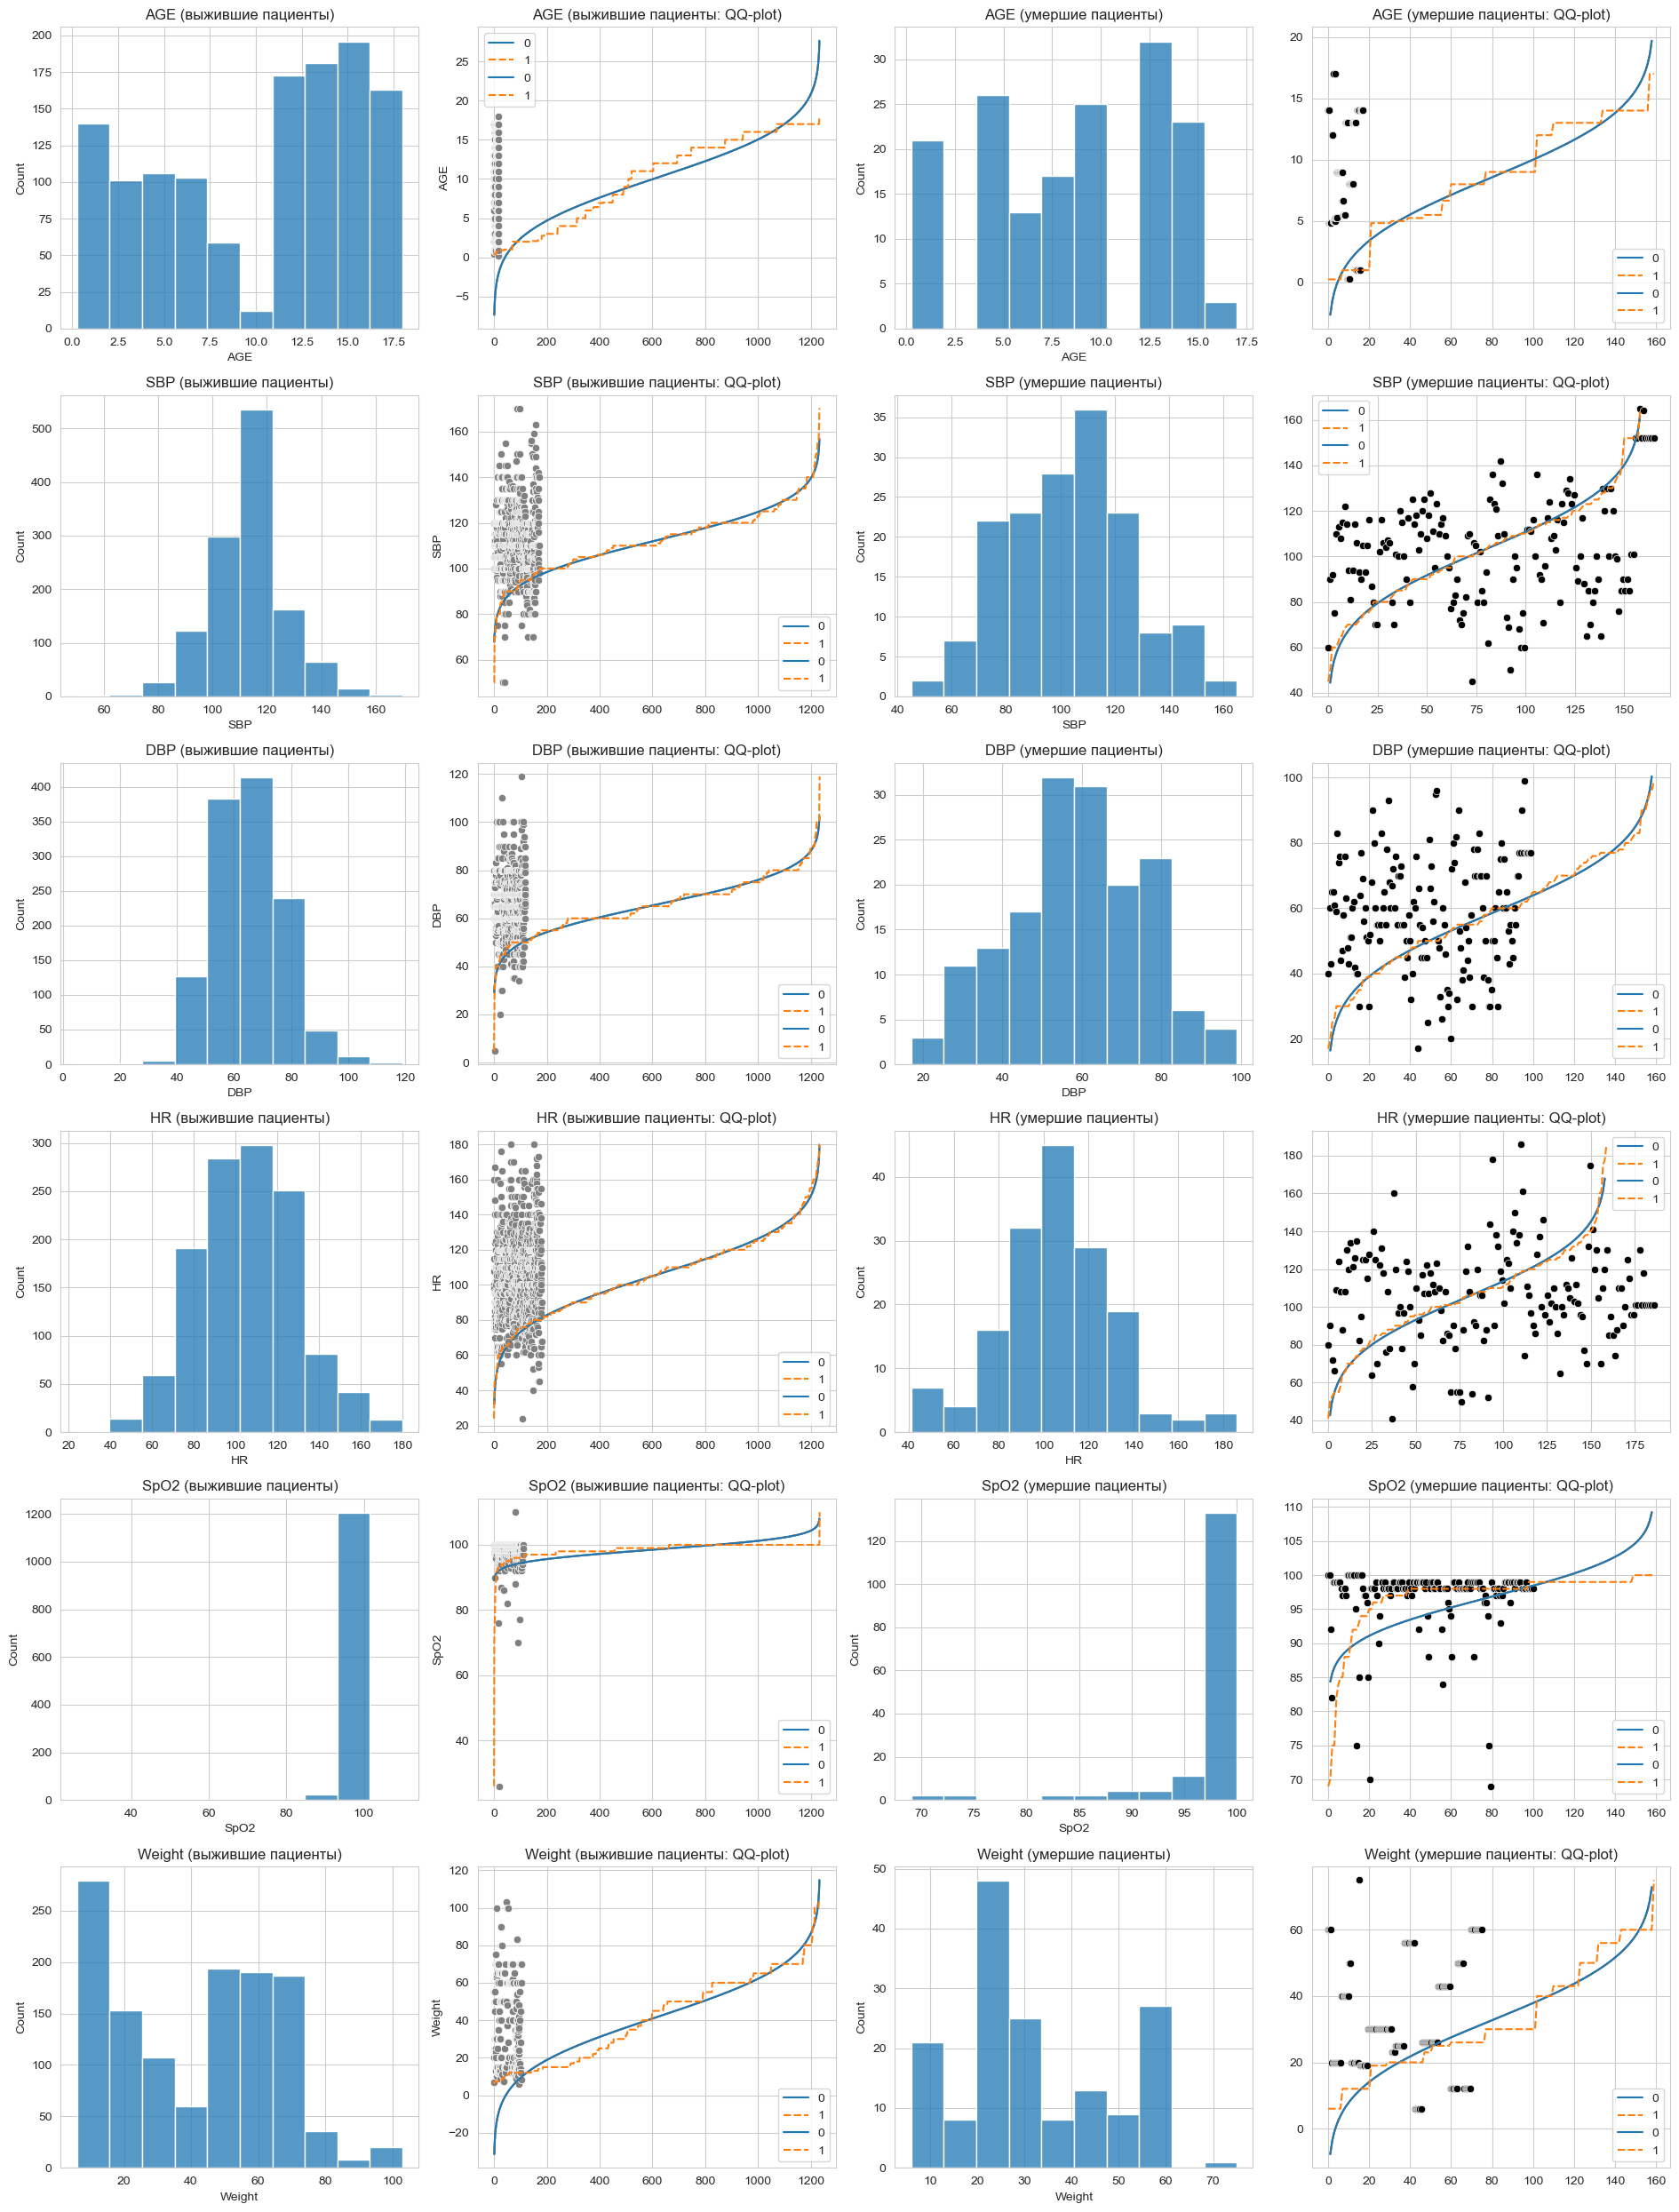

In [11]:
group0 = df[df['OUTCOME']=='Survived']
group1 = df[df['OUTCOME']=='Died']
figure,ax = plt.subplots(6,4,figsize=(19,25))
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    sns.histplot(group0[i],bins=10,ax=ax[k,0])
    interval = np.linspace(0,1,int(group0[i].count()))
    x = s.norm.ppf(np.linspace(0,1,int(group0[i].count())),loc=group0[i].mean(),scale=group0[i].std(ddof=1))
    y = np.quantile(group0[i],interval)
    sns.lineplot(data= [x,x],ax=ax[k,1],color='r')
    sns.lineplot(data=[x,y],ax=ax[k,1],color='b')
    sns.scatterplot(x=np.linspace(0,int(group0[i].max()),int(group0[i].count())),y=group0[i],ax=ax[k,1],color='grey')
    sns.histplot(group1[i],bins=10,ax=ax[k,2])
    interval = np.linspace(0,1,int(group1[i].count()))
    x = s.norm.ppf(np.linspace(0,1,int(group1[i].count())),loc=group1[i].mean(),scale=group1[i].std(ddof=1))
    y = np.quantile(group1[i],interval)
    sns.lineplot(data= [x,x],ax=ax[k,3],color='r')
    sns.lineplot(data= [x,y],ax=ax[k,3],color='b')
    sns.scatterplot(x=np.linspace(0,int(group1[i].max()),int(group1[i].count())),y=group1[i].values,ax=ax[k,3],color='black')
    ax[k,0].set_title(i+' (выжившие пациенты)')
    ax[k,1].set_title(i+' (выжившие пациенты: QQ-plot)')
    ax[k,2].set_title(i+' (умершие пациенты)')
    ax[k,3].set_title(i+' (умершие пациенты: QQ-plot)')
    plt.tight_layout()
plt.show()